# Imports

In [ ]:
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Preprocessing data

In [2]:
data_dir = pathlib.Path('/tmp/data').with_suffix('')
training_ds = tf.keras.utils.image_dataset_from_directory(
    directory=data_dir,
    color_mode='grayscale',
    validation_split=0.1,
    subset='training',
    image_size=(100, 100),
    batch_size=16,
    seed=522437
)
validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory=data_dir,
    color_mode='grayscale',
    validation_split=0.1,
    subset='validation',
    image_size=(100, 100),
    batch_size=16,
    seed=522437
)

Found 1762 files belonging to 24 classes.
Using 1586 files for training.
Found 1762 files belonging to 24 classes.
Using 176 files for validation.


In [3]:
class_names = training_ds.class_names
num_classes = len(class_names)

class_names, num_classes

(['upper-case-a',
  'upper-case-b',
  'upper-case-c',
  'upper-case-d',
  'upper-case-e',
  'upper-case-f',
  'upper-case-g',
  'upper-case-h',
  'upper-case-i',
  'upper-case-j',
  'upper-case-k',
  'upper-case-l',
  'upper-case-m',
  'upper-case-n',
  'upper-case-o',
  'upper-case-p',
  'upper-case-r',
  'upper-case-s',
  'upper-case-t',
  'upper-case-u',
  'upper-case-w',
  'upper-case-x',
  'upper-case-y',
  'upper-case-z'],
 24)

In [4]:
training_ds = training_ds.cache().shuffle(1762).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

training_ds = training_ds.map(lambda x, y: (tf.divide(x, 255), y))
validation_ds = validation_ds.map(lambda x, y: (tf.divide(x, 255), y))

# Preview the data

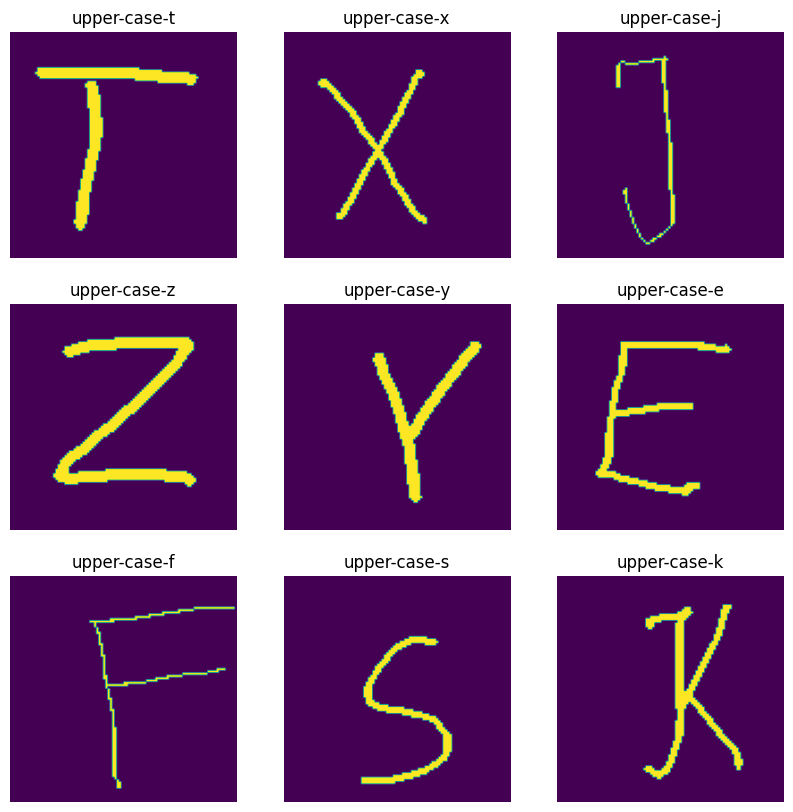

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

# Model architecture

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(100, 100, 1)),
    tf.keras.layers.Conv2D(8, 5, activation='relu', kernel_initializer='variance_scaling'),
    tf.keras.layers.MaxPooling2D(strides=(2, 2)),
    tf.keras.layers.Conv2D(16, 5, activation='relu', kernel_initializer='variance_scaling'),
    tf.keras.layers.MaxPooling2D(strides=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=num_classes, activation='softmax', kernel_initializer='variance_scaling'),
])

In [7]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 8)         208       
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 16)        3216      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 16)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 7744)              0         
                                                                 
 dense (Dense)               (None, 24)                1

In [8]:
history = model.fit(
    training_ds,
    validation_data=validation_ds,
    epochs=6
)

Epoch 1/6
100/100 [==============================] - 4s 30ms/step - loss: 1.4659 - accuracy: 0.6154 - val_loss: 0.7161 - val_accuracy: 0.8295
Epoch 2/6
100/100 [==============================] - 3s 29ms/step - loss: 0.2945 - accuracy: 0.9306 - val_loss: 0.5574 - val_accuracy: 0.8693
Epoch 3/6
100/100 [==============================] - 3s 29ms/step - loss: 0.0650 - accuracy: 0.9842 - val_loss: 0.4811 - val_accuracy: 0.9034
Epoch 4/6
100/100 [==============================] - 3s 28ms/step - loss: 0.0167 - accuracy: 0.9956 - val_loss: 0.5323 - val_accuracy: 0.8920
Epoch 5/6
100/100 [==============================] - 3s 29ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.5627 - val_accuracy: 0.9034
Epoch 6/6
100/100 [==============================] - 3s 29ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.6015 - val_accuracy: 0.8977


# Accuracy & loss plots

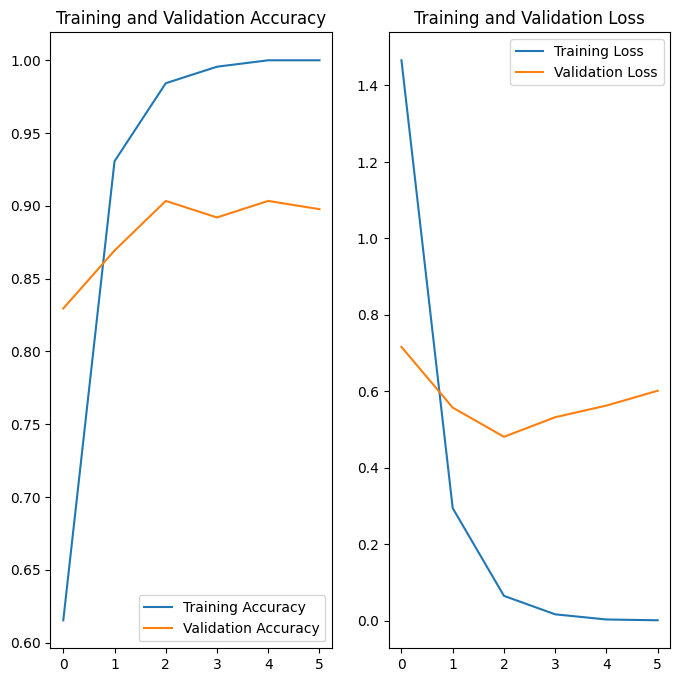

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(6)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Preview predictions

In [10]:
image = tf.keras.preprocessing.image.load_img(
    '/tmp/data/upper-case-m/1691665536687.png',
    target_size=(100, 100),
    color_mode='grayscale'
)
image_array = tf.keras.utils.img_to_array(image)
image_array = tf.expand_dims(image_array, 0)

predictions = model.predict(image_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 66ms/step
This image most likely belongs to upper-case-m with a 10.57 percent confidence.


# Confusion matrix

6/6 [==============================] - 0s 12ms/step


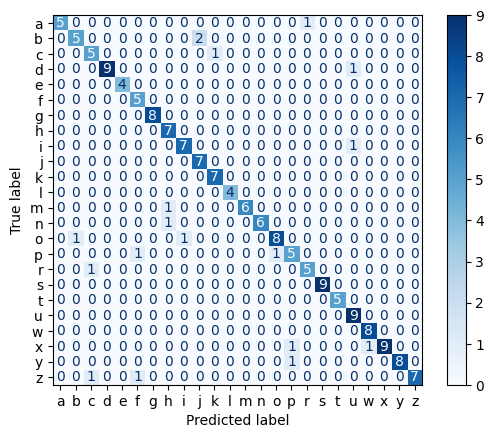

In [11]:
test_images, test_labels = zip(*validation_ds.unbatch().as_numpy_iterator())
test_images = np.array(test_images)
test_labels = np.array(test_labels)

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

matrix = confusion_matrix(test_labels, predicted_labels, labels=range(num_classes))

display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=[s[-1] for s in class_names])
display.plot(cmap=plt.cm.Blues, values_format='.4g')

plt.show()

# Save the model

In [12]:
model.save('/tmp/models/model.keras');